# Change Detection Examples

These examples show how to set up, run, and produce output from detectors in the 
change_detection module. The parameters aren't necessarily tuned for best 
performance for the input data, just notional.

Circle is a synthetic data source, where drift occurs in both var1, var2, and the 
conditional distributions P(y|var1) and P(y|var2). The drift occurs from index 
1000 to 1250, and affects 66% of the sample.

Rainfall is a real source of weather data. We use the first 1000 samples, where
no drift has been injected; but many features are cyclical, and haven't been
corrected, so change does occur.

These change detectors can be applied to any given single variable; below, 
they are applied to var2.

In [1]:
## Imports ##

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from menelaus.change_detection import ADWIN, CUSUM, PageHinkley
from menelaus.datasets import fetch_circle_data, fetch_rainfall_data

In [2]:
## Import Data ##

# read in Circle dataset
df = fetch_circle_data()
drift_start, drift_end = 1000, 1250

rainfall_df = fetch_rainfall_data()

## Cumulative Sum (CUSUM) Test

- This monitors a moving average of var2, starting from an initial estimate of mean
and standard deviation.

- It will only alarm if 50 or more samples have been observed since
initialization/drift.

- This will alarm if var2 passes a critical value controlled by delta and
threshold in either direction, positive or negative.



In [5]:
## Setup ##
cusum = CUSUM(
    target=np.mean(df.loc[:drift_start, "var2"]),  # mean / std of 'Var 2' pre-drift
    sd_hat=np.std(df.loc[:drift_start, "var2"]),
    burn_in=50,
    delta=0.005,
    threshold=40,
    direction=None,
)

# setup DF to record results
status = pd.DataFrame(columns=["index", "actual value", "drift_detected"])

# iterate through data; feed each sample to the detector, in turn
for i in range(len(df)):
    obs = df["var2"][i]
    cusum.update(obs)
    status.loc[i] = [i, obs, cusum.drift_state]

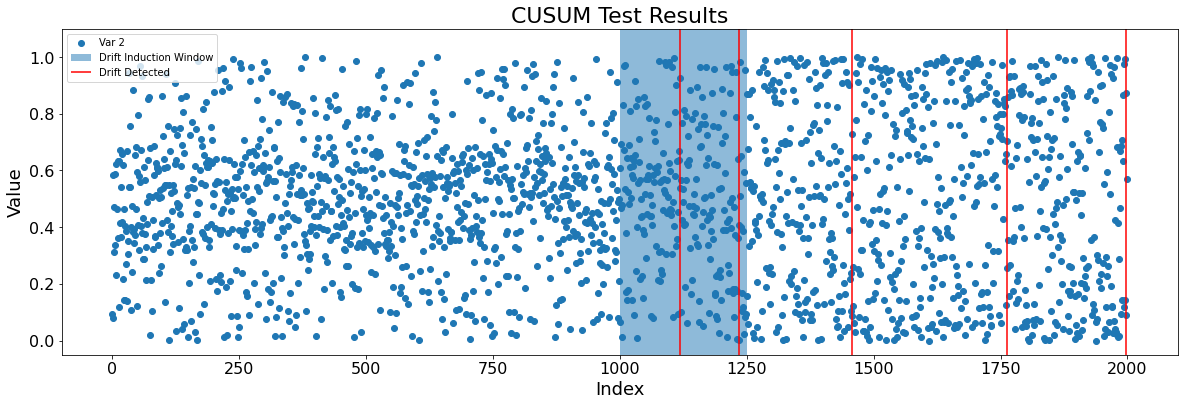

In [6]:
## Plotting ##

# plot the monitored variable and the status of the detector
plt.figure(figsize=(20, 6))
plt.scatter("index", "actual value", data=status, label="Var 2")
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("CUSUM Test Results", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)
ylims = [-0.05, 1.1]
plt.ylim(ylims)

plt.axvspan(drift_start, drift_end, alpha=0.5, label="Drift Induction Window")

plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Drift Detected",
    color="red",
)
plt.legend()

CUSUM alarms several times within the drift induction window, roughly halfway
through. After the alarm is reset, change is detected a few more times,
including an apparently erroneous detection after the drift induction window
is passed. The current threshold settings may then be too sensitive for the
new regime.


In [7]:

plt.show()
# plt.savefig("example_CUSUM_detections.png")

## Page-Hinkley (PH) Test

In [ ]:
## Setup ##

# Set up one-directional PH test: this will only alarm if the mean of the
# monitored variable decreases, and only after seeing 30 or more samples.
ph = PageHinkley(delta=0.01, threshold=15, direction="negative", burn_in=30)

# setup DF to record results
status = pd.DataFrame(columns=["index", "actual value", "drift_detected"])

# iterate through data; feed each sample to the detector, in turn
for i in range(len(df)):
    obs = df["var2"][i]
    ph.update(X=obs)
    status.loc[i] = [i, obs, ph.drift_state]

In [ ]:
## Plotting ##

# plot the monitored variable and the status of the detector
plt.figure(figsize=(20, 6))
plt.scatter("index", "actual value", data=status, label="Var 2")
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("PH Test Results", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)
ylims = [-0.05, 1.1]
plt.ylim(ylims)

plt.axvspan(drift_start, drift_end, alpha=0.5, label="Drift Induction Window")

plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Drift Detected",
    color="red",
)
plt.legend()
plt.show()
# plt.savefig("example_Page-Hinkley_detections.png")

Page-Hinkley alarms shortly after the drift induction window closes, and then makes
several apparently erroneous alarms afterwards. The parameters may not be
well-chosen for the new regime.
Change detection algorithms come out of process control, so a priori
characterization of the bounds of the process, not performed here, would not
be unreasonable.


# ADaptive WINdowing (ADWIN)

ADWIN is a change detection algorithm that can be used to monitor a real-valued number. ADWIN maintains a window of the data stream, which grows to the right as new elements are received. When the mean of the feature in one of the subwindows is different enough, ADWIN drops older elements in its window until this ceases to be the case.

In [58]:
## Setup ##

adwin = ADWIN()

# setup DF to record results
status = pd.DataFrame(columns=["index", "actual value", "drift_detected", "ADWIN mean"])
df2 = rainfall_df.loc[:1000, 'max_sustained_wind_speed']
rec_list = []

# iterate through data; feed each sample to the detector, in turn
for i in range(len(df2)):
    obs = df2[i]
    adwin.update(X=obs)
    status.loc[i] = [i, obs, adwin.drift_state, adwin.mean()]

    #monitor the size of ADWIN's window as it changes
    if adwin.drift_state == "drift":
        retrain_start = adwin.retraining_recs[0]
        retrain_end = adwin.retraining_recs[1]
        rec_list.append([retrain_start, retrain_end])

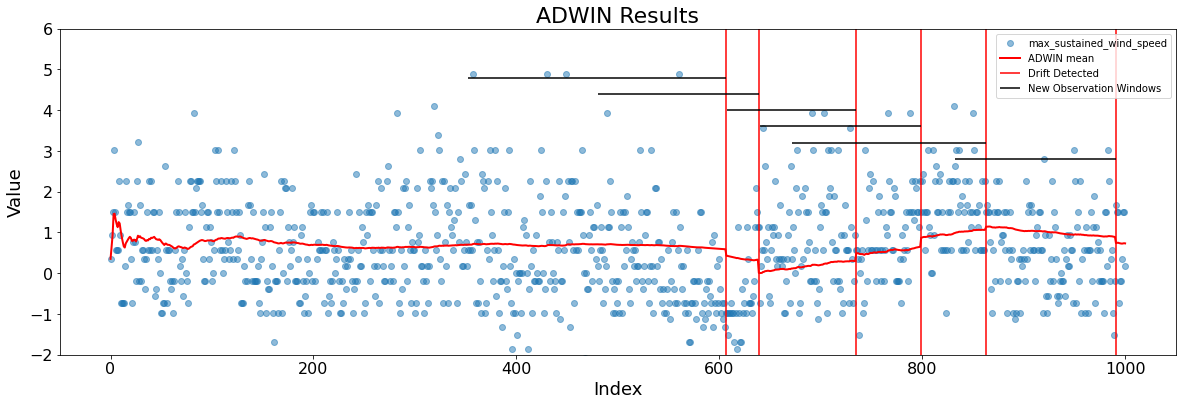

In [66]:
## Plotting ##

# plot the monitored variable and the status of the detector
plt.figure(figsize=(20, 6))
plt.scatter("index", "actual value", data=status, label="max_sustained_wind_speed", alpha=.5)
plt.plot("index", "ADWIN mean", data=status, color='red', linewidth=2)
plt.grid(False, axis="x")
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("ADWIN Results", fontsize=22)
plt.ylabel("Value", fontsize=18)
plt.xlabel("Index", fontsize=18)
ylims = [-2, 6]
plt.ylim(ylims)

plt.vlines(
    x=status.loc[status["drift_detected"] == "drift"]["index"],
    ymin=ylims[0],
    ymax=ylims[1],
    label="Drift Detected",
    color="red",
)

# Create a list of lines that indicate the retraining windows.
# Space them evenly, vertically.
rec_list = pd.DataFrame(rec_list)
rec_list["y_val"] = np.linspace(
    start=0.6 * (ylims[1] - ylims[0]) + ylims[0],
    stop=0.8 * ylims[1],
    num=len(rec_list),
)

# Draw green lines that indicate where retraining occurred
plt.hlines(
    y=rec_list["y_val"][::-1],
    xmin=rec_list[0],
    xmax=rec_list[1],
    color="black",
    label="New Observation Windows",
)

plt.legend()
plt.show()
# plt.savefig("example_ADWIN.png")

ADWIN monitors the running average of the `max_sustained_wind_speed` column and, once that mean begins to change enough around index 600, shrinks its observation window (in black) to only include more recent samples. This process repeats as further changes are detected. We can see that the size of the observation window shrinks and grows as the incoming data changes.